In [82]:
pip install category_encoders

In [83]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# import torch.nn as nn
# import torch.optim as optim
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVR
# import torch
import category_encoders as ce
%matplotlib inline
from sklearn.preprocessing import LabelEncoder


In [84]:
train = pd.read_csv("/content/drive/My Drive/Online_Contest/Janata_Healthcare_Analytics_2/Data/train.csv")
test = pd.read_csv("/content/drive/My Drive/Online_Contest/Janata_Healthcare_Analytics_2/Data/test.csv")

In [85]:
print("Size of Train data: %d \nSize Test data: %d"%(len(train),len(test)))

Size of Train data: 318438 
Size Test data: 137057


In [86]:
print("Num of columns in Data : %d\nColumns are....."%(len(train.columns)))
print(train.columns)

Num of columns in Data : 18
Columns are.....
Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')


In [87]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [88]:
test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


Combining both test and train to for data cleaning while removing 'Stay' columns from train data for now



In [89]:
train_target =  train['Stay']
del train['Stay']

train['Train'] = 1
test['Train'] = 0

In [90]:
data = pd.concat([train,test],ignore_index=True)
data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Train
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,1


## Data Cleaning

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455495 entries, 0 to 455494
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            455495 non-null  int64  
 1   Hospital_code                      455495 non-null  int64  
 2   Hospital_type_code                 455495 non-null  object 
 3   City_Code_Hospital                 455495 non-null  int64  
 4   Hospital_region_code               455495 non-null  object 
 5   Available Extra Rooms in Hospital  455495 non-null  int64  
 6   Department                         455495 non-null  object 
 7   Ward_Type                          455495 non-null  object 
 8   Ward_Facility_Code                 455495 non-null  object 
 9   Bed Grade                          455347 non-null  float64
 10  patientid                          455495 non-null  int64  
 11  City_Code_Patient                  4488

create Heatmap to check which column has nan values

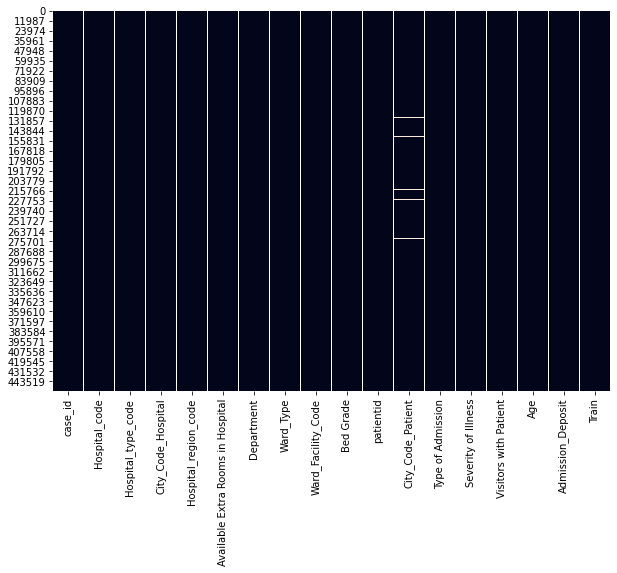

In [92]:
plt.figure(figsize=(10,7))
sb.heatmap(data.isnull(), cbar=False)
# sb.heatmap(data.isna(), cbar=False)

Only 'City_Code_Patient' has missing values. 

In [93]:
print("Num of missing in City_Code_Patient Column: %d"%(data.City_Code_Patient.isnull().sum()))

Num of missing in City_Code_Patient Column: 6689


As the code '8' for City_Code_Patient' is most frequent we will fill the missing entry with id '8'.

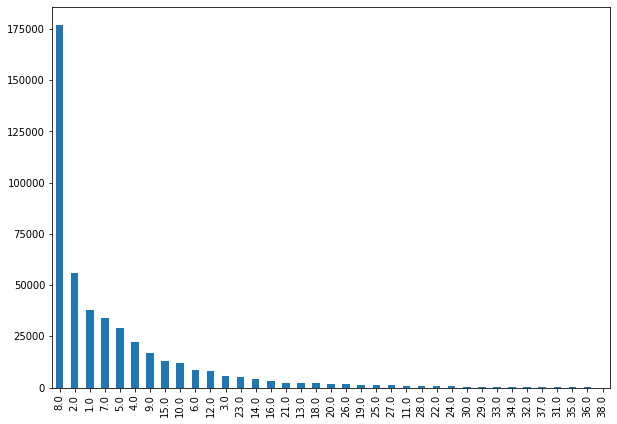

In [94]:
data.City_Code_Patient.value_counts().plot(kind = "bar", figsize = [10,7])

In [95]:
data['City_Code_Patient'] = data['City_Code_Patient'].fillna(8.0)

In [96]:
print("Num of missing in City_Code_Patient Column: %d"%(data.City_Code_Patient.isnull().sum()))

Num of missing in City_Code_Patient Column: 0


In [97]:
data['Bed Grade'] = data['Bed Grade'].fillna(0)

## Feature Enginnering

So now data is totally cleaned now we can do some feature engineering on the data

In [98]:
data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Train
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,1


As given target as range in string lets convert into integer with following format

- if range is more than 100 days => 95
- otherwise range_start - range_end => range_end - 5


In [99]:
new_train_target = [95 if len(days) > 6  else int(days[-2:])-5 for days in train_target]

Heat map to check the relation with numerical data and traget

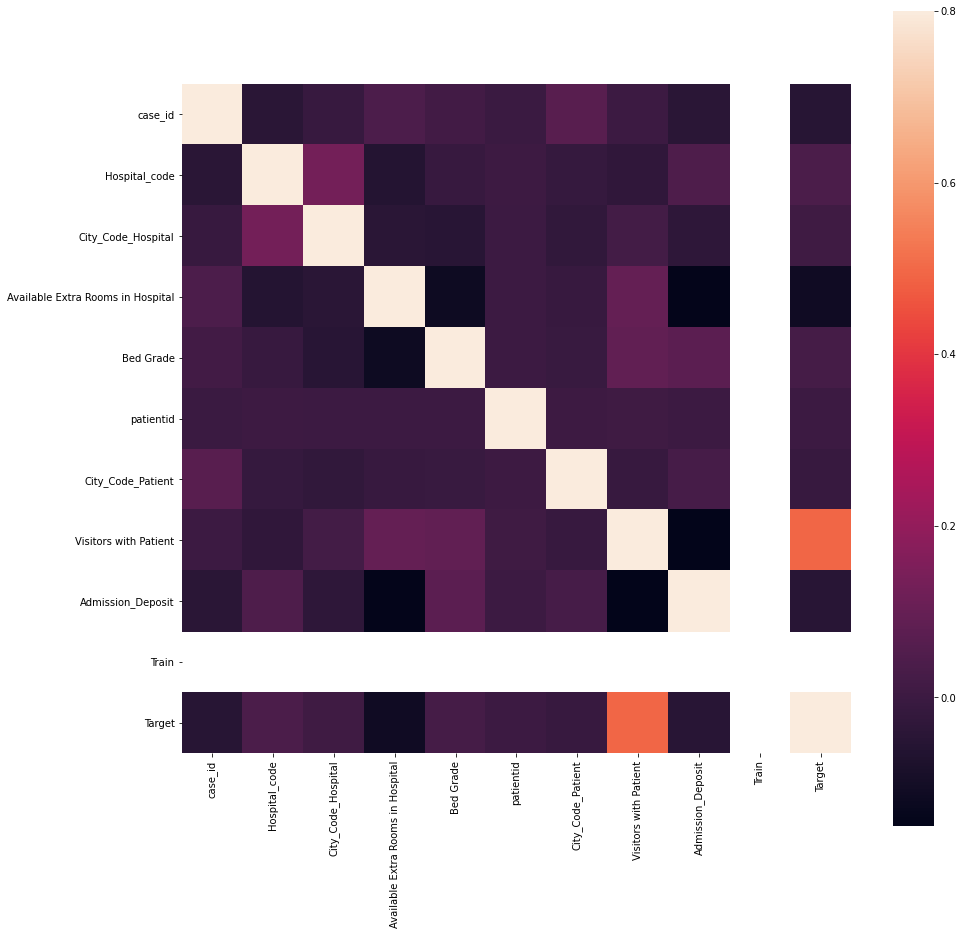

In [100]:

train_data = data[data['Train']==1].copy()
train_data['Target'] = new_train_target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

Some of the columns such as case_Id, Hospital_Id, patientId, city_code_patient are just information related to identity of the entity or person which is not useful for the taget prediction so we will just drop them for now.

In [101]:
# Train data columns
train_data_case_Id =  data[data['Train'] == 1]['case_id'].copy()
train_data_hospital_code =  data[data['Train'] == 1]['Hospital_code'].copy()
train_data_patient_Id =  data[data['Train'] == 1]['patientid'].copy()
# train_data_city_code_patient =  data[data['Train'] == 1]['City_Code_Patient'].copy()

# Test Data columns
test_data_case_Id =  data[data['Train'] == 0]['case_id'].copy()
test_data_hospital_code =  data[data['Train'] == 0]['Hospital_code'].copy()
test_data_patient_Id =  data[data['Train'] == 0]['patientid'].copy()
# test_data_city_code_patient =  data[data['Train'] == 0]['City_Code_Patient'].copy()

# deleting the columns
del data['case_id']
del data['Hospital_code']
del data['patientid']
# del data['City_Code_Patient']

Seperate the numerical columns and categorical columns. 


In [102]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return predictors

In [103]:
categorical_col = get_cols_with_no_nans(data,'no_num')
numerical_col =  get_cols_with_no_nans(data, 'num')

In [104]:
categorical_col.head()

,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Severity of Illness,Age
0,c,Z,radiotherapy,R,F,Emergency,Extreme,51-60
1,c,Z,radiotherapy,S,F,Trauma,Extreme,51-60
2,e,X,anesthesia,S,E,Trauma,Extreme,51-60
3,b,Y,radiotherapy,R,D,Trauma,Extreme,51-60
4,b,Y,radiotherapy,S,D,Trauma,Extreme,51-60


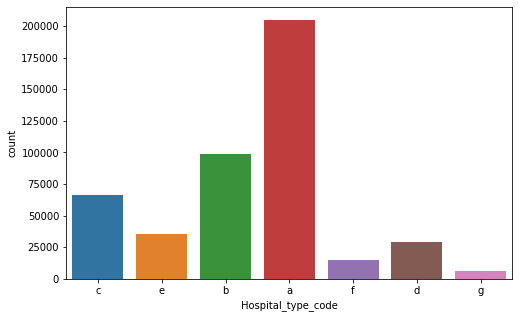

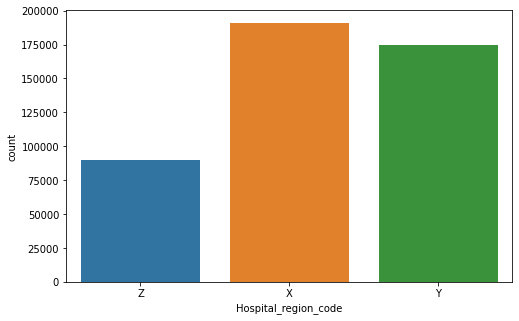

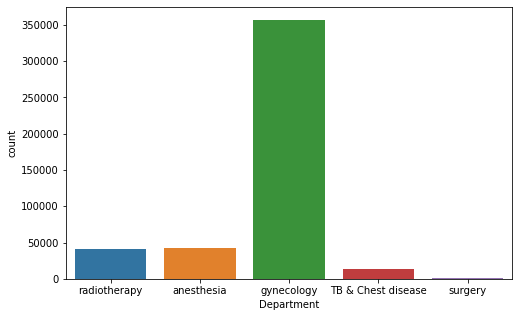

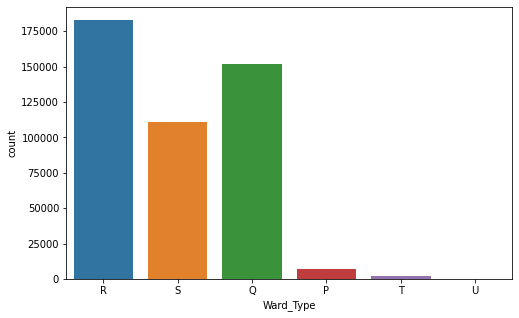

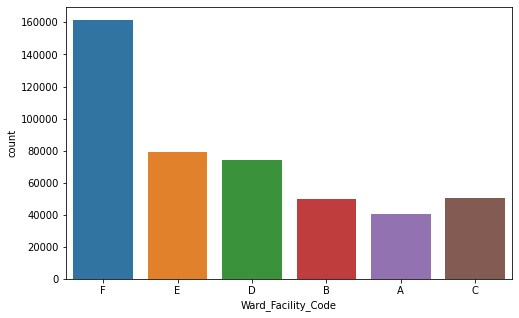

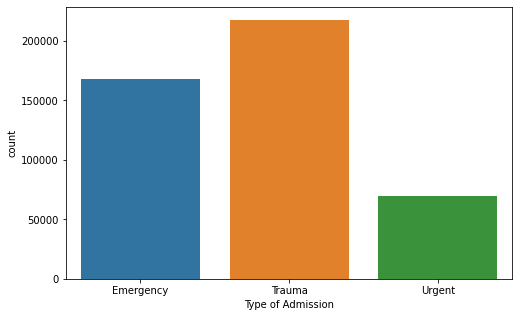

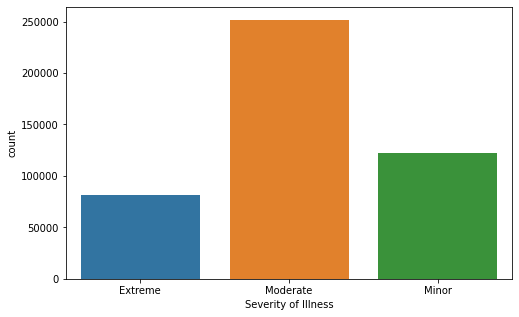

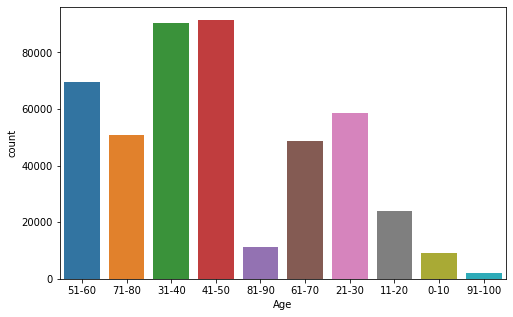

In [76]:
for col in categorical_col.columns:
#     categorical_col[col].value_counts().plot(kind='bar',figsize=[10,3])
    plt.figure(figsize = (8,5))
    sb.countplot(x=col,data=categorical_col)
    plt.show()

## Feature Engineering

In [105]:
#Create object for binary encoding
encoder = ce.BinaryEncoder(cols=['Hospital_type_code'], return_df=True)
categorical_col = encoder.fit_transform(categorical_col)  
categorical_col = categorical_col.drop(columns=['Hospital_type_code_0'])

In [106]:
encoder = ce.BinaryEncoder(cols=['Hospital_region_code'], return_df=True)
categorical_col = encoder.fit_transform(categorical_col)  
categorical_col = categorical_col.drop(columns=['Hospital_region_code_0'])

In [107]:
encoder = ce.BinaryEncoder(cols=['Department'], return_df=True)
categorical_col = encoder.fit_transform(categorical_col)  
categorical_col = categorical_col.drop(columns=['Department_0'])
# categorical_col['Department']

In [108]:
encoder = ce.BinaryEncoder(cols=['Ward_Facility_Code'], return_df=True)
categorical_col = encoder.fit_transform(categorical_col)  
categorical_col = categorical_col.drop(columns=['Ward_Facility_Code_0'])

In [109]:
# Create object for hash encoder
encoder=ce.HashingEncoder(cols='Ward_Type',n_components=3)
categorical_col = encoder.fit_transform(categorical_col)
categorical_col = categorical_col.rename(columns={"col_0": "Ward_Type_0",
                                                  "col_1": "Ward_Type_1",
                                                  "col_2": "Ward_Type_2",})

In [110]:
encoder=ce.HashingEncoder(cols='Type of Admission',n_components=2)
categorical_col = encoder.fit_transform(categorical_col)
categorical_col = categorical_col.rename(columns={"col_0": "Type of Admission_0", "col_1": "Type of Admission_1"})

In [111]:
categorical_col['Severity of Illness'] = categorical_col['Severity of Illness'].map({
    'Minor': 1,
    'Moderate': 2,
    'Extreme' : 3
})

In [112]:
age_dict = {'0-10':5,'11-20':15,'21-30':25,'31-40':35,
           '51-60':55, '71-80':75, '41-50':45, '81-90':85,
            '61-70':65, '91-100':95}

categorical_col['Age'] = categorical_col['Age'].map(age_dict)

In [113]:
categorical_col.head()

,Type of Admission_0,Type of Admission_1,Ward_Type_0,Ward_Type_1,Ward_Type_2,Hospital_type_code_1,Hospital_type_code_2,Hospital_type_code_3,Hospital_region_code_1,Hospital_region_code_2,Department_1,Department_2,Department_3,Ward_Facility_Code_1,Ward_Facility_Code_2,Ward_Facility_Code_3,Severity of Illness,Age
0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,3,55
1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,3,55
2,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,3,55
3,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,3,55
4,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,3,55


Few rows of BED Grade column has none which filled with 0

In [ ]:
numerical_col.head()

,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,Visitors with Patient,Admission_Deposit,Train
0,3,3,2.0,2,4911.0,1
1,5,2,2.0,2,5954.0,1
2,1,2,2.0,2,4745.0,1
3,2,2,2.0,2,7272.0,1
4,2,2,2.0,2,5558.0,1


In [114]:
new_data = pd.concat([numerical_col,categorical_col],axis=1)

In [115]:
new_data.head()

,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,City_Code_Patient,Visitors with Patient,Admission_Deposit,Train,Type of Admission_0,Type of Admission_1,Ward_Type_0,Ward_Type_1,Ward_Type_2,Hospital_type_code_1,Hospital_type_code_2,Hospital_type_code_3,Hospital_region_code_1,Hospital_region_code_2,Department_1,Department_2,Department_3,Ward_Facility_Code_1,Ward_Facility_Code_2,Ward_Facility_Code_3,Severity of Illness,Age
0,3,3,2.0,7.0,2,4911.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,3,55
1,5,2,2.0,7.0,2,5954.0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,3,55
2,1,2,2.0,7.0,2,4745.0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,3,55
3,2,2,2.0,7.0,2,7272.0,1,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,3,55
4,2,2,2.0,7.0,2,5558.0,1,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,3,55


In [116]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455495 entries, 0 to 455494
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   City_Code_Hospital                 455495 non-null  int64  
 1   Available Extra Rooms in Hospital  455495 non-null  int64  
 2   Bed Grade                          455495 non-null  float64
 3   City_Code_Patient                  455495 non-null  float64
 4   Visitors with Patient              455495 non-null  int64  
 5   Admission_Deposit                  455495 non-null  float64
 6   Train                              455495 non-null  int64  
 7   Type of Admission_0                455495 non-null  int64  
 8   Type of Admission_1                455495 non-null  int64  
 9   Ward_Type_0                        455495 non-null  int64  
 10  Ward_Type_1                        455495 non-null  int64  
 11  Ward_Type_2                        4554

# train, test data

In [117]:
new_train = new_data[new_data['Train']== 1]
new_test = new_data[new_data['Train'] == 0]

# As we dont require the Train columns anymore
new_train = new_train.drop(columns=['Train'])
new_test = new_test.drop(columns=['Train'])

# Utility Functions

In [37]:
def getClassOfPrediction(prediction):
    new_prediction = []
    for pred in prediction:
        if pred <= 10:
            new_prediction.append(5)
        elif pred >= 91:
            new_prediction.append(95)
        else:
            new_prediction.append(int(pred/10) * 10 + 5)

    return new_prediction

def getSubmissionTypePred(prediction):
    new_prediction = []

    for pred in prediction:

        if pred == 5:
            new_prediction.append("0-10")
        else:
            new_prediction.append(str(int(pred)-4)+'-'+str(int(pred)+5))

    return new_prediction

# Classification

In [121]:
XGBclf = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators = 2400,
              objective='multi:softmax',booster = 'gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
            max_delta_step=0,min_child_weight=1.5,
             n_jobs=1, nthread=None,reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1,tree_method='gpu_hist', gpu_id=0)

In [ ]:
kf = KFold(n_splits=5)
n_iter = 0
Acc = 0
new_train_target_1 = pd.Series(new_train_target)
new_train_xgb =  new_train.copy()

for train_index, test_index in kf.split(new_train):

    n_iter += 1
    
    # print(type(train_index))
    X_train, X_val = new_train_xgb.iloc[train_index], new_train_xgb.iloc[test_index]
    y_train, y_val = new_train_target_1.iloc[train_index], new_train_target_1.iloc[test_index]


    XGBclf.fit(np.array(X_train), y_train , verbose=False)
    XGBpredictions = XGBclf.predict(np.array(X_val))

    print("Accuracy for iteration %d is %3.4f"%(n_iter,accuracy_score(y_val, getClassOfPrediction(XGBpredictions))))
    
    Acc += accuracy_score(y_val, getClassOfPrediction(XGBpredictions))
    

print('Average Accuracy is %3.4f'%(Acc / 5))

In [123]:
XGBclf.fit(np.array(new_train), new_train_target , verbose=False)
XGBpredictions_1 = XGBclf.predict(np.array(new_test))

In [124]:
XGBRegScore = getSubmissionTypePred(getClassOfPrediction(XGBpredictions_1))


In [125]:
result = {"case_id":test.case_id,"Stay":XGBRegScore}

result_df = pd.DataFrame(result)

result_df.set_index('case_id', inplace=True)

result_df.to_csv("/content/drive/My Drive/Online_Contest/Janata_Healthcare_Analytics_2/Data/predicion4.csv")

In [ ]:
XGBclfpredictions = XGBModel.predict(np.array(X_val))